# Notebook machine learning

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

 

Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.

Pour réaliser ce modèle, Michaël, votre manager, vous a fourni le jeu de données suivant qui contient :

un historique de prêts ;
un historique d’informations financières ;
des informations sur le comportement des emprunteurs (si l’emprunteur a fait défaut ou pas). 

# Etape 1 : choisir un kernel et effectuer une analyse exploratoire

Assurez-vous de comprendre la problématique métier et l'objectif du projet avant de commencer.

Contexte business
"Prêt à dépenser" est une société financière spécialisée dans une niche particulière : les clients avec peu ou pas d'historique de crédit. C'est un segment de marché à la fois prometteur et risqué :

Prometteur car il représente une clientèle mal servie par les banques traditionnelles (jeunes adultes, nouveaux arrivants, personnes en reconversion professionnelle)
Risqué car l'absence d'historique rend difficile l'évaluation de la solvabilité

Enjeux clés pour l'entreprise
1. Équilibre risque/opportunité

Trop restrictif → perte de clients potentiellement rentables, croissance limitée
Faux négatif (refuser un bon client) → perte d'opportunité commerciale

Trop laxiste → défauts de paiement élevés, pertes financières importantes
Faux positif (accepter un mauvais payeur) → perte financière directe

2. Besoin d'automatisation intelligente
Le volume de demandes nécessite un système automatisé capable de :

Traiter rapidement les demandes (décision en temps réel ou quasi temps réel)
Maintenir une cohérence dans les décisions
S'appuyer sur des données objectives plutôt que sur l'intuition

3. Contrainte d'interprétabilité
C'est un point crucial souvent négligé en data science. Les chargés de relation client doivent pouvoir :

Expliquer la décision au client (obligation légale dans certains pays avec le RGPD)
Comprendre les facteurs déterminants pour conseiller le client
Négocier ou ajuster si nécessaire avec une compréhension claire des risques



In [4]:
import timeit

start = timeit.default_timer()

In [5]:
# Standard Library
import timeit
import warnings
from collections import Counter

# Data Manipulation
import pandas as pd
import numpy as np
import polars as pl

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn - Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

# Scikit-learn - Preprocessing & Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Scikit-learn - Model Selection & Evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Imbalanced Learning
from imblearn.over_sampling import SMOTE

# Explainability
import shap

# Configuration
warnings.filterwarnings('ignore')


In [6]:
shap.initjs()

In [7]:
df_original = pd.read_csv("../exploratory/application_ready_for_machine_learning.csv")

In [8]:
# Calcul de la matrice de confusion

def plot_confusion_matrix(y_t, y_p): #y_test et y_prédiction
    cm = confusion_matrix(y_t, y_p)

    # Affichage
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Ticks et labels
    classes = np.unique(y_t)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel='Prédiction',
        ylabel='Vrai label',
        title='Matrice de confusion'
    )

    # Rotation des labels en abscisse
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Annotation des cases
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black'
            )

    plt.tight_layout()
    plt.show()

Je peux mettre le code ci dessous à la fin du notebook exploratoire

In [9]:
#autre méthode : on peut également dropper des NaN

df = df_original.dropna()
df.shape

(100000, 27)

In [10]:
df.sample(5)

,Unnamed: 0,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,...,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
71935,71935,0.539874,0.090527,0.588488,0.0,11.184421,278613.0,22733.0,-3097.8,12.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
55023,55023,0.675175,0.525450,0.609276,0.0,11.050890,254700.0,24217.0,-4179.8,15.2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27934,27934,0.444185,0.125744,0.239226,0.0,12.660328,447768.0,10806.0,-2941.0,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
54567,54567,0.478344,0.443698,0.372334,0.0,12.049419,760225.5,15654.0,-555.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
33593,33593,0.734639,0.636324,0.586740,0.0,11.744037,589045.5,20725.0,-2388.2,9.8,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Définition overfitting

Underfitting (sous-apprentissage) : le modèle est trop simple (fort biais), il n’apprend pas la structure des données.

Bon équilibre (biais-variance tradeoff) : le modèle capture la tendance principale sans suivre le bruit.

Overfitting : le modèle devient trop flexible (forte variance), il suit le bruit et perd en pouvoir de prédiction.

### Causes de l'overfitting

Modèle trop complexe : trop de paramètres (haute capacité), p. ex. polynôme de degré élevé, réseau de neurones très profond.

Taille de l’échantillon insuffisante : peu de données d’entraînement par rapport à la complexité du modèle.

Bruitage élevé dans les données : le modèle apprend le bruit plutôt que le signal. 

### Rappel du contexte 

l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Question : quelle est ma target ? Est-ce la variable target ?

In [11]:
df

,Unnamed: 0,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,...,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special
0,0,0.083037,0.262949,0.139376,0.0,12.218495,406597.5,9461.0,-637.0,21.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0.311267,0.622246,0.626200,0.0,12.506177,1293502.5,16765.0,-1188.0,8.2,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,0.524142,0.555912,0.729567,0.0,11.119883,135000.0,19046.0,-225.0,26.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3,0.669315,0.650442,0.472277,0.0,11.813030,312682.5,19005.0,-3039.0,9.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,0.660904,0.322738,0.570941,0.0,11.707670,513000.0,19932.0,-3038.0,17.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0.469614,0.488676,0.284054,1.0,11.967181,755190.0,11838.0,-232.0,7.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
99996,99996,0.720055,0.539071,0.576209,1.0,12.323856,284400.0,13429.0,-182.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,99997,0.473838,0.605584,0.786267,0.0,11.813030,1262583.0,17626.0,-4805.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99998,99998,0.398054,0.611289,0.543859,0.0,11.813030,225000.0,12420.0,-340.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
df['TARGET'].value_counts()

KeyError: 'TARGET'

# Feature Engineering - Création de Variables Métier

Création de nouvelles variables pertinentes pour l'évaluation du risque crédit, basées sur l'expertise métier.

In [ ]:
def create_business_features(df):
    """
    Crée 3 nouvelles variables métier pertinentes pour l'évaluation du risque crédit
    
    Returns:
    --------
    df_enhanced : DataFrame
        DataFrame avec les nouvelles features
    feature_descriptions : dict
        Description des nouvelles variables créées
    """
    df_enhanced = df.copy()
    
    # Vérifier que les colonnes nécessaires existent
    required_cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN']
    missing_cols = [col for col in required_cols if col not in df_enhanced.columns]
    
    if missing_cols:
        print(f"⚠️ Colonnes manquantes pour feature engineering: {missing_cols}")
        print("Création de variables simplifiées...")
        
        # Feature simplifiée 1: SIMPLE_DEBT_RATIO
        if 'AMT_CREDIT' in df_enhanced.columns and 'AMT_INCOME_TOTAL' in df_enhanced.columns:
            df_enhanced['SIMPLE_DEBT_RATIO'] = df_enhanced['AMT_CREDIT'] / np.exp(df_enhanced['AMT_INCOME_TOTAL'])
        
        # Feature simplifiée 2: FAMILY_BURDEN
        if 'CNT_CHILDREN' in df_enhanced.columns:
            df_enhanced['FAMILY_BURDEN'] = df_enhanced['CNT_CHILDREN'] + 1
            
        # Feature simplifiée 3: HIGH_CREDIT_FLAG
        if 'AMT_CREDIT' in df_enhanced.columns:
            df_enhanced['HIGH_CREDIT_FLAG'] = (df_enhanced['AMT_CREDIT'] > df_enhanced['AMT_CREDIT'].quantile(0.75)).astype(int)
            
        feature_descriptions = {
            'SIMPLE_DEBT_RATIO': 'Ratio simple crédit/revenus',
            'FAMILY_BURDEN': 'Charge familiale (enfants + 1)',
            'HIGH_CREDIT_FLAG': 'Flag crédit élevé (>Q3)'
        }
        
        return df_enhanced, feature_descriptions
    
    # Feature 1: INCOME_STABILITY_SCORE (original code)
    df_enhanced['AGE_YEARS'] = -df_enhanced['DAYS_BIRTH'] / 365.25
    df_enhanced['EMPLOYMENT_YEARS'] = -df_enhanced['DAYS_EMPLOYED'] / 365.25
    
    # Normalisation et création du score (0-100)
    age_norm = (df_enhanced['AGE_YEARS'] - df_enhanced['AGE_YEARS'].min()) / (df_enhanced['AGE_YEARS'].max() - df_enhanced['AGE_YEARS'].min())
    emp_norm = np.clip(df_enhanced['EMPLOYMENT_YEARS'] / 40, 0, 1)  # Cap à 40 ans d'emploi
    
    df_enhanced['INCOME_STABILITY_SCORE'] = (age_norm * 0.6 + emp_norm * 0.4) * 100
    
    # Feature 2: FINANCIAL_BURDEN_RATIO  
    children_factor = df_enhanced['CNT_CHILDREN'] + 1
    df_enhanced['FINANCIAL_BURDEN_RATIO'] = (df_enhanced['AMT_CREDIT'] / np.exp(df_enhanced['AMT_INCOME_TOTAL'])) * children_factor
    
    # Feature 3: RISK_PROFILE_CATEGORY
    income_p75 = np.exp(df_enhanced['AMT_INCOME_TOTAL']).quantile(0.75)
    credit_p75 = df_enhanced['AMT_CREDIT'].quantile(0.75)
    age_p50 = df_enhanced['AGE_YEARS'].quantile(0.5)
    
    # Conditions pour le profil de risque
    conditions = [
        # Profil LOW_RISK
        (df_enhanced['AGE_YEARS'] >= age_p50) & 
        (np.exp(df_enhanced['AMT_INCOME_TOTAL']) >= income_p75) & 
        (df_enhanced['AMT_CREDIT'] <= credit_p75) &
        (df_enhanced.get('NAME_EDUCATION_TYPE_Higher education', False) == True),
        
        # Profil MEDIUM_RISK
        (df_enhanced['AGE_YEARS'] >= age_p50) | 
        (np.exp(df_enhanced['AMT_INCOME_TOTAL']) >= income_p75),
        
        # Profil HIGH_RISK
        (df_enhanced['AGE_YEARS'] < age_p50) & 
        (np.exp(df_enhanced['AMT_INCOME_TOTAL']) < income_p75) & 
        (df_enhanced['AMT_CREDIT'] > credit_p75)
    ]
    
    choices = ['LOW_RISK', 'MEDIUM_RISK', 'HIGH_RISK']
    df_enhanced['RISK_PROFILE_CATEGORY'] = np.select(conditions, choices, default='MEDIUM_RISK')
    
    # Encodage one-hot du profil de risque
    risk_dummies = pd.get_dummies(df_enhanced['RISK_PROFILE_CATEGORY'], prefix='RISK_PROFILE')
    df_enhanced = pd.concat([df_enhanced, risk_dummies], axis=1)
    
    # Suppression des variables temporaires
    df_enhanced = df_enhanced.drop(['AGE_YEARS', 'EMPLOYMENT_YEARS', 'RISK_PROFILE_CATEGORY'], axis=1)
    
    feature_descriptions = {
        'INCOME_STABILITY_SCORE': 'Score de stabilité financière (0-100) basé sur l age et l anciennete d emploi',
        'FINANCIAL_BURDEN_RATIO': 'Ratio de charge financière ajusté par le nombre d enfants',
        'RISK_PROFILE_LOW_RISK': 'Profil de risque faible (âge élevé, revenus élevés, éducation)',
        'RISK_PROFILE_MEDIUM_RISK': 'Profil de risque moyen',
        'RISK_PROFILE_HIGH_RISK': 'Profil de risque élevé (jeune, revenus faibles, crédit élevé)'
    }
    
    return df_enhanced, feature_descriptions

# Application de la feature engineering
print("=== Création des Variables Métier ===")
df_original_shape = df.shape
df_enhanced, descriptions = create_business_features(df)

print(f"Données originales: {df_original_shape}")
print(f"Données enrichies: {df_enhanced.shape}")
print(f"Nouvelles variables créées: {df_enhanced.shape[1] - df_original_shape[1]}")

print("\n=== Description des Nouvelles Variables ===")
for feature, description in descriptions.items():
    print(f"• {feature}: {description}")

# Analyse des nouvelles variables
print("\n=== Analyse des Nouvelles Variables ===")

# Get list of new features that actually exist
new_features = [col for col in list(descriptions.keys()) if col in df_enhanced.columns]

for feature in new_features:
    print(f"\n{feature}:")
    if df_enhanced[feature].dtype in ['int64', 'float64']:
        print(f"  Min: {df_enhanced[feature].min():.3f}")
        print(f"  Max: {df_enhanced[feature].max():.3f}")
        print(f"  Moyenne: {df_enhanced[feature].mean():.3f}")
        print(f"  Médiane: {df_enhanced[feature].median():.3f}")
    else:
        print(f"  Valeurs: {df_enhanced[feature].value_counts().to_dict()}")

# Mise à jour du DataFrame principal
df = df_enhanced.copy()
print(f"\n Feature engineering terminé! Nouvelles dimensions: {df.shape}")

=== Création des Variables Métier ===
Données originales: (12649, 29)
Données enrichies: (12649, 34)
Nouvelles variables créées: 5

=== Description des Nouvelles Variables ===
• INCOME_STABILITY_SCORE: Score de stabilité financière (0-100) basé sur l age et l anciennete d emploi
• FINANCIAL_BURDEN_RATIO: Ratio de charge financière ajusté par le nombre d enfants
• RISK_PROFILE_LOW_RISK: Profil de risque faible (âge élevé, revenus élevés, éducation)
• RISK_PROFILE_MEDIUM_RISK: Profil de risque moyen
• RISK_PROFILE_HIGH_RISK: Profil de risque élevé (jeune, revenus faibles, crédit élevé)

=== Analyse des Nouvelles Variables ===

INCOME_STABILITY_SCORE:
  Min: 6.038
  Max: 62.829
  Moyenne: 44.135
  Médiane: 46.013

FINANCIAL_BURDEN_RATIO:
  Min: 0.159
  Max: 69.600
  Moyenne: 5.961
  Médiane: 4.286

RISK_PROFILE_LOW_RISK:
  Valeurs: {False: 12181, True: 468}

RISK_PROFILE_MEDIUM_RISK:
  Valeurs: {True: 11127, False: 1522}

RISK_PROFILE_HIGH_RISK:
  Valeurs: {False: 11595, True: 1054}

 Fea

# Etape 1: Mettre en place un séparation test-train cohérente

In [ ]:
y = df['TARGET']
X = df.drop(columns=['TARGET', 'Unnamed: 0'])
X.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE,INCOME_STABILITY_SCORE,FINANCIAL_BURDEN_RATIO,RISK_PROFILE_HIGH_RISK,RISK_PROFILE_LOW_RISK,RISK_PROFILE_MEDIUM_RISK
6,100009,0,0.774761,0.724000,0.492060,True,False,1,12.049419,1560726.0,...,False,False,False,9.127053,85500.0,47.335650,18.254105,True,False,False
15,100019,0,0.115634,0.346634,0.678568,False,True,0,11.967181,299772.0,...,False,False,True,1.903314,157500.0,59.518457,1.903314,False,False,True
21,100025,0,0.437709,0.233767,0.542445,True,False,1,12.218495,1132573.5,...,False,False,True,5.592956,101250.0,39.678173,11.185911,True,False,False
28,100033,0,0.600396,0.685011,0.524496,False,True,0,12.506177,790830.0,...,False,False,False,2.929000,270000.0,56.859609,2.929000,False,True,False
51,100059,0,0.311510,0.713355,0.309275,False,True,1,13.199324,675000.0,...,False,False,False,1.250000,270000.0,40.966067,2.500000,False,False,True


## Oversampling avec SMOTE

In [ ]:
X_train_before_oversampling, X_test, y_train_before_oversampling, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

SMOTE (Synthetic Minority Over-sampling Technique) is one of the most widely used methods for dealing with class imbalance in classification problems. Instead of simply duplicating minority‐class samples, SMOTE creates new synthetic examples by interpolating between existing ones.

In [ ]:
X_train, y_train = SMOTE(
    #sampling_strategy=0.5,  # minority will be 50% of majority
    sampling_strategy='auto',
    k_neighbors=5, #k_neighbors (par défaut 5)
    random_state=42
).fit_resample(X_train_before_oversampling, y_train_before_oversampling)

print("Before:", Counter(y_train_before_oversampling))
print("After: ", Counter(y_train))

print(X_train.shape)
print(X_test.shape)

Before: Counter({0: 7906, 1: 568})
After:  Counter({0: 7906, 1: 7906})
(15812, 32)
(4175, 32)


On a fait un split Train Test, maintanent on va entrainer des modèles dessus

# 1. Entrainement des modèles

## a. Modèles linéaires : régressions logistique

Régression logistique
Modèle linéaire qui estime la probabilité d’appartenance à la classe 1 via la fonction log‑it.
Interprétable : chaque coefficient → impact d’une variable sur le log‑odds.
Rapide à entraîner, fonctionne bien si la frontière est (à peu près) linéaire.
Sensibilité aux variables corrélées et aux outliers.

In [ ]:
model_logistique = LogisticRegression(random_state=0)

In [ ]:
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE,INCOME_STABILITY_SCORE,FINANCIAL_BURDEN_RATIO,RISK_PROFILE_HIGH_RISK,RISK_PROFILE_LOW_RISK,RISK_PROFILE_MEDIUM_RISK
0,183973,0,0.292119,0.520922,0.554947,False,True,1,11.967181,773680.500000,...,False,False,True,4.912257,78750.000000,49.688457,9.824514,False,False,True
1,111402,0,0.224215,0.232344,0.501075,False,True,1,11.630709,775327.500000,...,False,False,True,6.891800,56250.000000,46.961014,13.783600,False,False,True
2,175933,1,0.385694,0.492403,0.477649,False,True,0,11.184421,135000.000000,...,True,False,False,1.875000,72000.000000,47.255665,1.875000,False,False,True
3,119770,0,0.571992,0.563177,0.119119,True,False,1,11.630709,244584.000000,...,False,False,True,2.174080,56250.000000,43.559309,4.348160,False,False,True
4,192284,0,0.192368,0.777648,0.770087,False,True,0,12.218495,679500.000000,...,False,False,False,3.355556,202500.000000,56.853762,3.355556,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15807,151394,0,0.143081,0.367638,0.186068,True,True,0,11.827206,223616.214290,...,False,False,True,1.635338,137034.669718,50.391494,1.635338,False,False,True
15808,109737,0,0.181962,0.505512,0.593691,False,True,0,12.461723,519295.562856,...,False,False,True,2.013604,258734.873373,46.410133,2.013604,False,False,True
15809,188521,0,0.246831,0.540146,0.379501,True,True,1,11.197928,147515.520364,...,False,False,True,2.016064,36501.266169,51.920072,4.032128,False,False,True
15810,205817,0,0.185099,0.627242,0.236214,True,True,1,12.231987,785837.386260,...,False,False,True,3.833134,102690.620308,48.198143,7.666268,False,False,True


En se servant du jeu de données d'entraienemtn, on a entrainé le modèle sur le jeu de modèle d'entrainement

In [ ]:
model_logistique.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
print(y_train.sum())
print(y_train.shape)

y_pred = model_logistique.predict(X_test)
y_proba = model_logistique.predict_proba(X_test)[:, 1]

print(y_proba.shape)


7906
(15812,)
(4175,)


In [ ]:
y_train.sum()


np.int64(7906)

In [ ]:
y_train.shape

(15812,)

In [ ]:
y_pred = model_logistique.predict(X_test)

In [ ]:
y_pred

array([0, 0, 1, ..., 0, 0, 0], shape=(4175,))

Le modèle est mauvais et ne prédit pas correctement

In [ ]:
y_proba = model_logistique.predict_proba(X_test)[:, 1]
y_proba

array([0.44766547, 0.27592428, 0.53770677, ..., 0.44532247, 0.47128339,
       0.45539829], shape=(4175,))

In [ ]:
y_proba.shape

(4175,)

(array([  18.,   55.,  165.,  347.,  768., 1237., 1137.,  326.,   68.,
          54.]),
 array([0.0394766 , 0.11824081, 0.19700502, 0.27576923, 0.35453344,
        0.43329765, 0.51206186, 0.59082607, 0.66959028, 0.74835449,
        0.8271187 ]),
 <BarContainer object of 10 artists>)

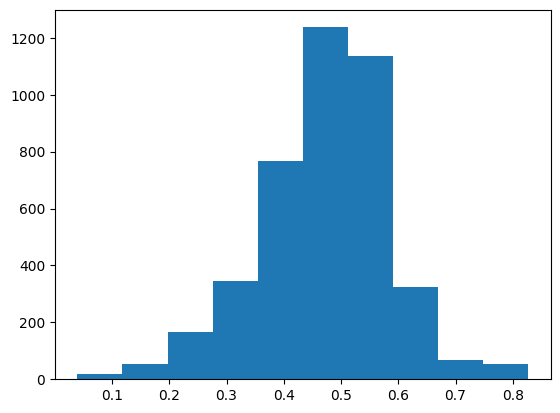

In [ ]:
plt.hist(y_proba)

### C - Résultats

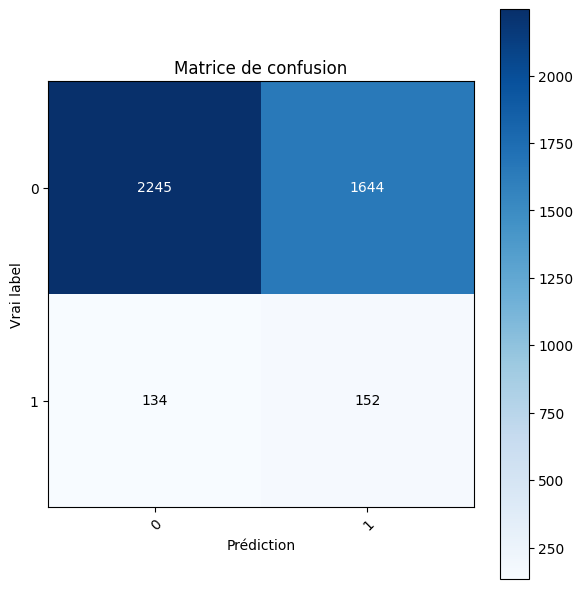

In [ ]:
plot_confusion_matrix(y_test, y_pred)

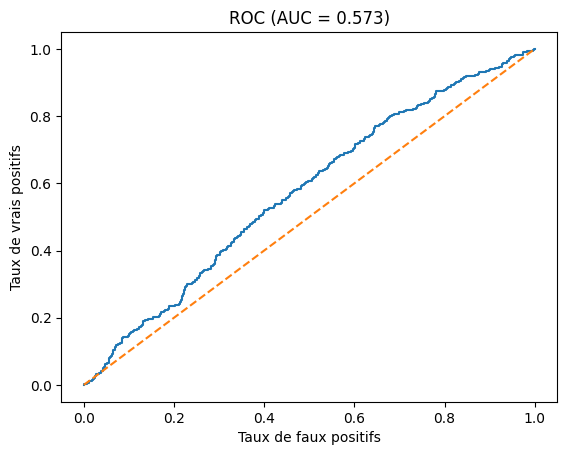

In [ ]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


### D - Explanability and feature importance

In [ ]:
# Coefficients and Odds Ratios
coefficients = model_logistique.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


Feature Importance (Coefficient and Odds Ratio):
                                              Feature   Coefficient  \
12                                        OWN_CAR_AGE  1.869912e-02   
27                             INCOME_STABILITY_SCORE  1.218976e-02   
24  NAME_EDUCATION_TYPE_Secondary / secondary special  9.553537e-03   
6                                       CODE_GENDER_M  9.142072e-03   
19                           NAME_INCOME_TYPE_Working  7.356965e-03   
14              NAME_INCOME_TYPE_Commercial associate  4.633150e-03   
5                                       CODE_GENDER_F  3.858724e-03   
31                           RISK_PROFILE_MEDIUM_RISK  2.304281e-03   
21               NAME_EDUCATION_TYPE_Higher education  1.842510e-03   
8                                    AMT_INCOME_TOTAL  1.709713e-03   
25                                  CREDIT_DEBT_RATIO  1.296033e-03   
29                             RISK_PROFILE_HIGH_RISK  1.206730e-03   
16                     NAME

# E - Shap

In [ ]:
# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model_logistique, X_train)
shap_values = explainer(X_test)

print("SHAP values calculated successfully!")
print(f"Shape of SHAP values: {shap_values.values.shape}")
print(f"Base value: {shap_values.base_values[0]}")

SHAP values calculated successfully!
Shape of SHAP values: (4175, 32)
Base value: 0.01866235285365703


Beeswarm plot failed with error: loop of ufunc does not support argument 0 of type float which has no callable rint method
Using alternative SHAP visualization...


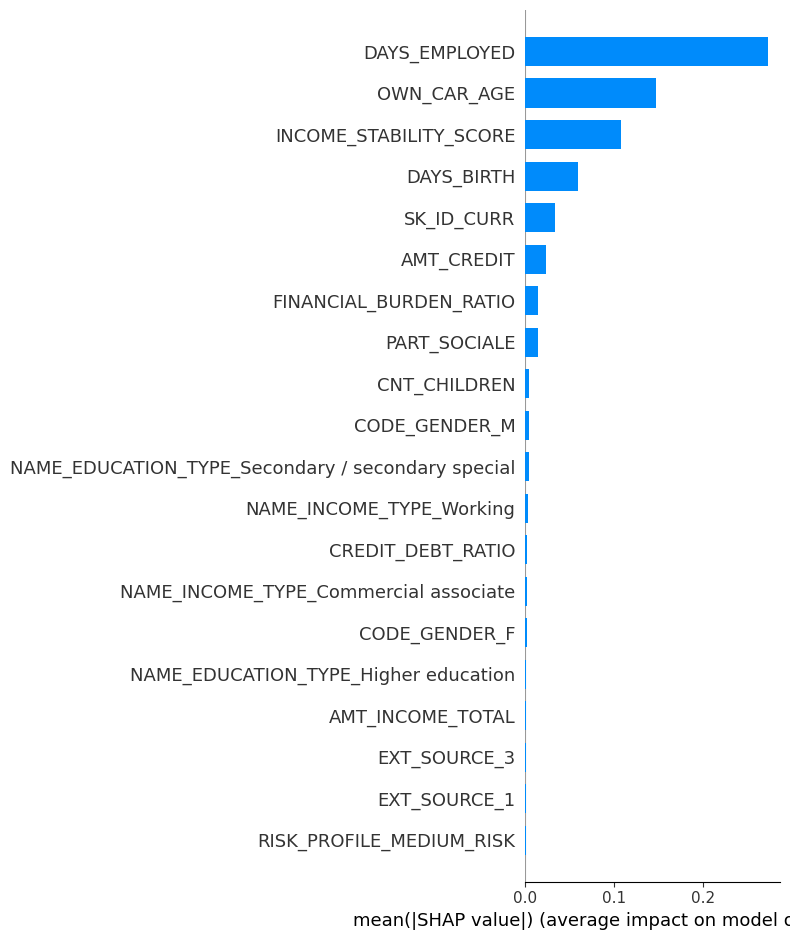

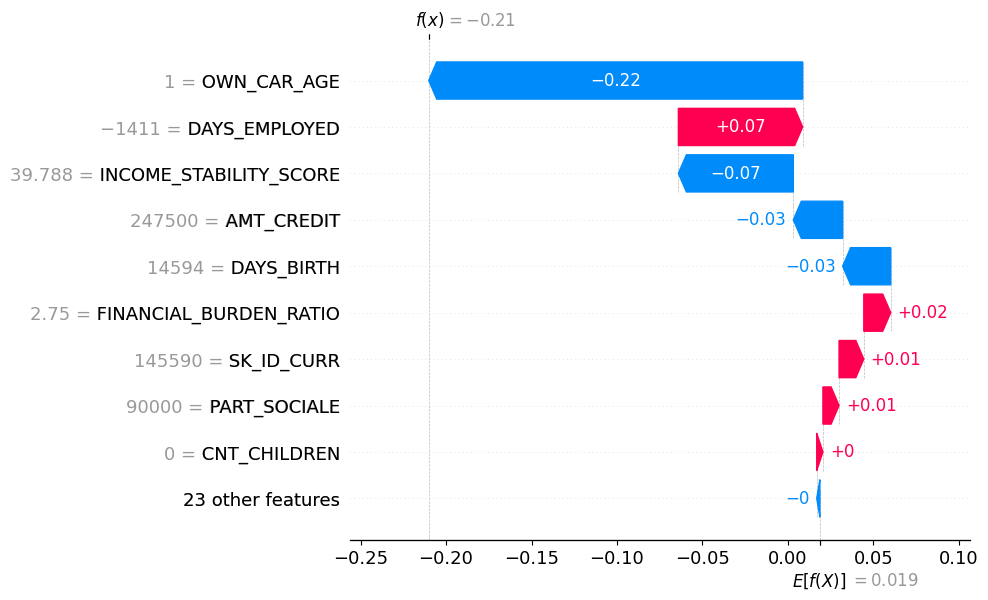

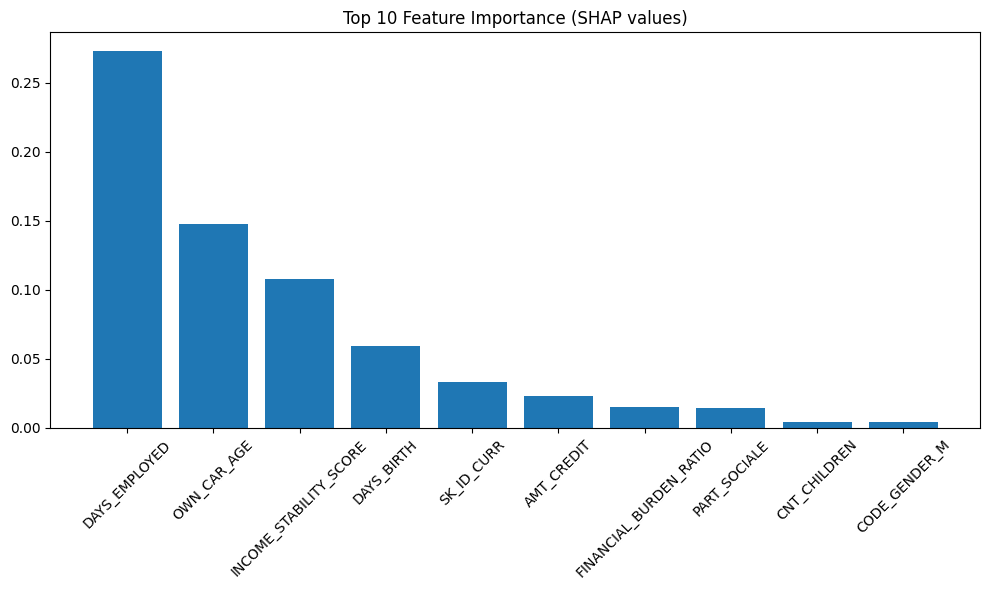

In [ ]:
try:
    shap.plots.beeswarm(shap_values)
except (TypeError, AttributeError) as e:
    print(f"Beeswarm plot failed with error: {e}")
    print("Using alternative SHAP visualization...")
    
    # Alternative 1: Use summary plot
    shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns, plot_type="bar")
    
    # Alternative 2: Use waterfall plot for first instance
    shap.plots.waterfall(shap_values[0])
    
    # Alternative 3: Manual feature importance plot
    import matplotlib.pyplot as plt
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = X_test.columns
    
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1][:10]  # Top 10 features
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
    plt.title("Top 10 Feature Importance (SHAP values)")
    plt.tight_layout()
    plt.show()

In [ ]:
ind = 0
shap.plots.force(shap_values[ind])

# Étape 2: Fonction de Coût Métier

Dans le contexte du crédit, les erreurs ont des coûts différents :
- **Faux Négatif (FN)** : Mauvais client prédit comme bon → Crédit accordé → Perte de capital
- **Faux Positif (FP)** : Bon client prédit comme mauvais → Crédit refusé → Manque à gagner

**Hypothèse métier** : Le coût d'un FN est **10 fois supérieur** au coût d'un FP

## Optimisation du Seuil de Décision

Le seuil par défaut de 0.5 n'est pas forcément optimal pour minimiser le coût métier. 
Nous allons trouver le seuil qui minimise le coût total.

## Score "Métier" pour Comparaison des Modèles

Nous allons créer une fonction qui évalue chaque modèle avec son seuil optimal et calcule le score métier final.

## Interprétabilité Métier du Meilleur Modèle

Analyse détaillée de l'interprétabilité pour les chargés de clientèle, avec focus sur le modèle optimal.

# Etape 2 : il me faut un modèle benchmark (Dummy)

Pourquoi un modèle Dummy :  Si mon modèle de ML n’arrive pas à faire mieux qu’un modèle sans features, c’est que mes features n’apportent pas une grande valeur ajoutée.

In [ ]:
dummy_regressor = DummyRegressor()
dummy_classifier = DummyClassifier()
dummy_regressor.fit(X_train, y_train)
dummy_classifier.fit(X_train, y_train)
dummy_regressor.fit(X_train, y_train)
dummy_classifier.fit(X_train, y_train)

DummyClassifier()

In [ ]:
df.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_GENDER_F',
       'CODE_GENDER_M', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
       'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'CREDIT_DEBT_RATIO', 'PART_SOCIALE', 'INCOME_STABILITY_SCORE',
       'FINANCIAL_BURDEN_RATIO', 'RISK_PROFILE_HIGH_RISK',
       'RISK_PROFILE_LOW_RISK', 'RISK_PROFILE_MEDIUM_RISK'],
      dtype='object')

# Comparaison de chaque modèle

Faire des parties A, B et C avec chaque modèle, et commenter

### A - Entrainement (Fit)

### B - Prédictions (Predict)

(array([  18.,   55.,  165.,  347.,  768., 1237., 1137.,  326.,   68.,
          54.]),
 array([0.0394766 , 0.11824081, 0.19700502, 0.27576923, 0.35453344,
        0.43329765, 0.51206186, 0.59082607, 0.66959028, 0.74835449,
        0.8271187 ]),
 <BarContainer object of 10 artists>)

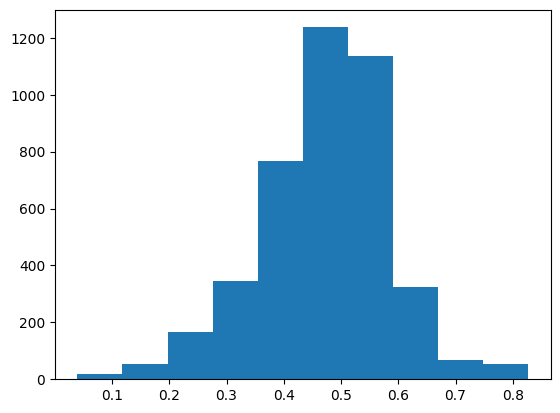

In [ ]:
model_logistique = LogisticRegression(random_state=0)
X_train
model_logistique.fit(X_train, y_train)
y_pred = model_logistique.predict(X_test)
y_proba = model_logistique.predict_proba(X_test)[:, 1]
y_proba
plt.hist(y_proba)

### C - résultats

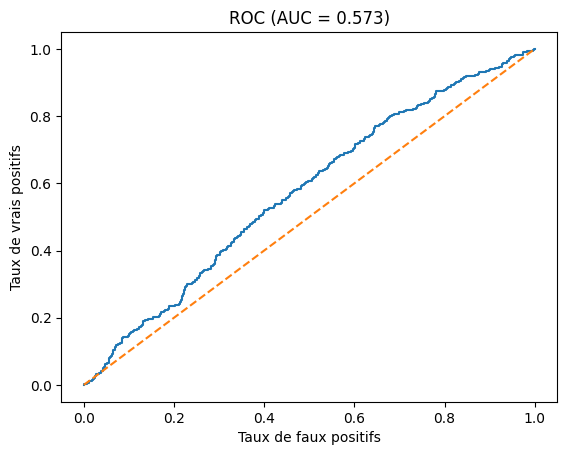

In [ ]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


In [ ]:
# choisis un seuil, par ex. 0.5
#y_pred_label = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))

[[2245 1644]
 [ 134  152]]


Si le modèle arrivait à prédire tous les 1 parfaitement, on devrait avoir 286 en bas à droite

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      3889
           1       0.08      0.53      0.15       286

    accuracy                           0.57      4175
   macro avg       0.51      0.55      0.43      4175
weighted avg       0.88      0.57      0.68      4175



Le modèle est très mauvais pour prédire les 1

### Decision tree

In [ ]:
# 1. Instanciation
model_decisiontree = DecisionTreeClassifier(random_state=0, max_depth=5)  

In [ ]:
# 2. Entraînement
model_decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [ ]:
# 3. Prédiction
y_pred_dt   = model_decisiontree.predict(X_test)
y_proba_dt  = model_decisiontree.predict_proba(X_test)[:,1]

In [ ]:
# 4. Évaluation
print("ROC AUC (DT) :", roc_auc_score(y_test, y_proba_dt))

ROC AUC (DT) : 0.6626570909162834


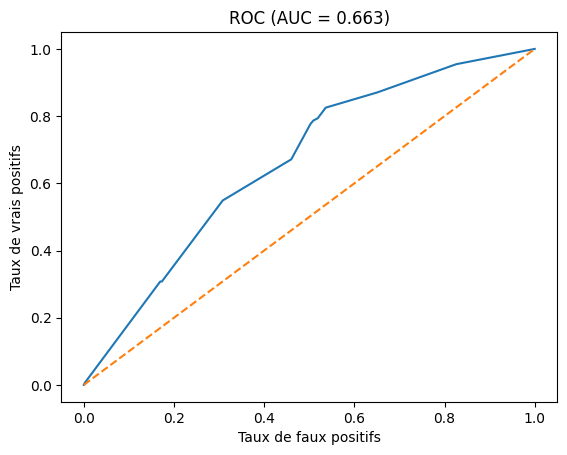

In [ ]:
auc_dt = roc_auc_score(y_test, y_proba_dt)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc_dt:.3f})")
plt.show()

### Random Forest

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=0,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)
y_proba_rf = model_rf.predict_proba(X_test)[:,1]
print("ROC AUC (RF) :", roc_auc_score(y_test, y_proba_rf))



ROC AUC (RF) : 0.7033433909880297


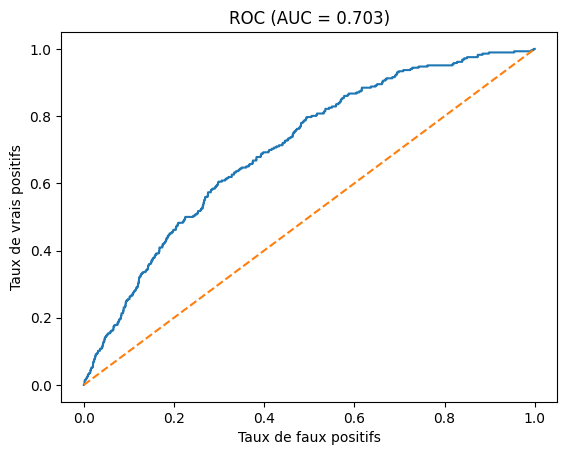

In [ ]:
auc = roc_auc_score(y_test, y_proba_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


## Gradient boosting

Addition séquentielle d’arbres faibles corrigeant les erreurs des précédents (boosting).  
Très performant sur données tabulaires, mais sensible au bruit et aux hyperparamètres.  
Nécessite souvent un réglage fin (learning rate, n_estimators, max_depth).  
Plus lent à entraîner qu’une random forest.  

ROC AUC (GB) : 0.7300994197368588


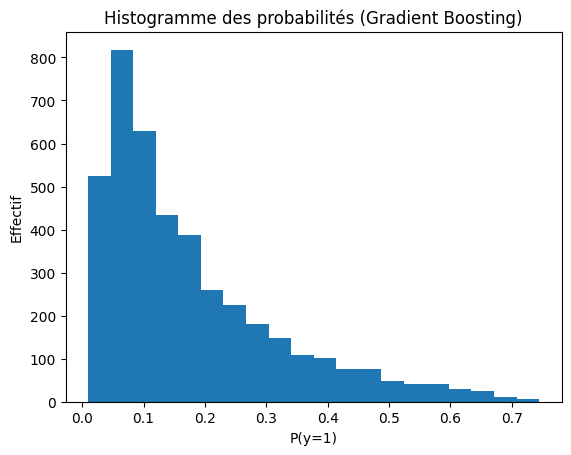

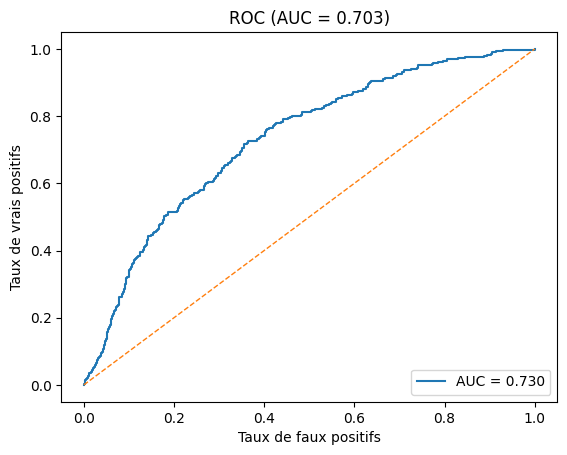

In [ ]:
model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=0
)

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
y_proba_gb = model_gb.predict_proba(X_test)[:,1]
print("ROC AUC (GB) :", roc_auc_score(y_test, y_proba_gb))

plt.hist(y_proba_gb, bins=20)
plt.title("Histogramme des probabilités (Gradient Boosting)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_gb = roc_auc_score(y_test, y_proba_gb)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_gb)
plt.plot(fpr, tpr, label=f"AUC = {auc_gb:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred_gb))
print("-------")
print("Classification report")
print(classification_report(y_test, y_pred_gb))

Confusion matrix
[[3734  155]
 [ 259   27]]
-------
Classification report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3889
           1       0.15      0.09      0.12       286

    accuracy                           0.90      4175
   macro avg       0.54      0.53      0.53      4175
weighted avg       0.88      0.90      0.89      4175



J'ai toujours beaucoup d'overfitting à 0

## KNN classifier

Classe un point selon la majorité des k voisins les plus proches dans l’espace des features.  
Simple, non paramétrique, adapté aux frontières complexes.  
Coût de prédiction élevé (recherche de voisins), nécessite normalisation des variables.  
Sensibilité à la dimensionnalité et au choix de k.  

ROC AUC (KNN) : 0.587482715279064


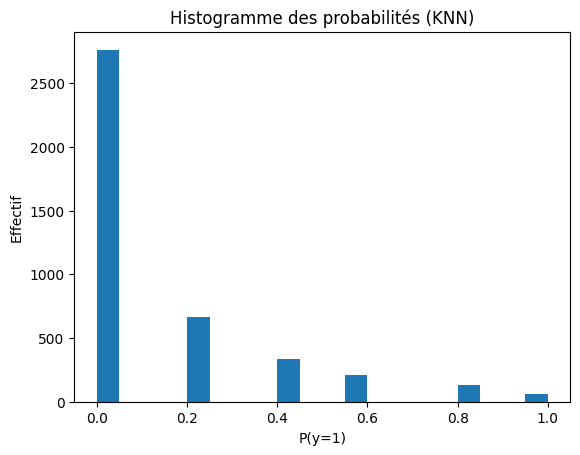

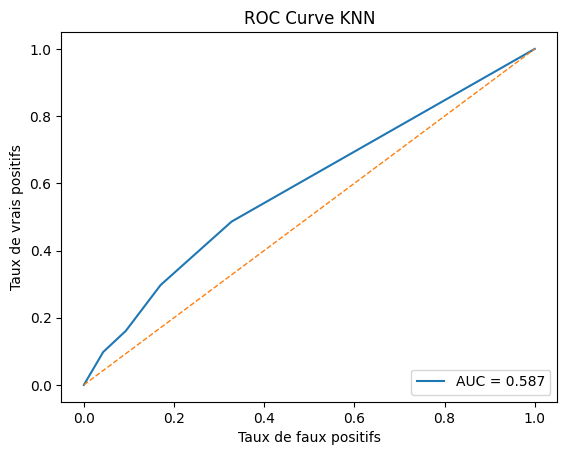

In [ ]:
# On crée un pipeline qui standardise puis applique KNN
model_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

model_knn.fit(X_train, y_train)
y_proba_knn = model_knn.predict_proba(X_test)[:,1]
print("ROC AUC (KNN) :", roc_auc_score(y_test, y_proba_knn))

plt.hist(y_proba_knn, bins=20)
plt.title("Histogramme des probabilités (KNN)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_knn = roc_auc_score(y_test, y_proba_knn)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_knn)
plt.plot(fpr, tpr, label=f"AUC = {auc_knn:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve KNN")
plt.legend(loc="lower right")
plt.show()

## Support Vector Machine

Trouve l’hyperplan maximisant la marge entre classes, peut utiliser des noyaux non linéaires.  
Efficace en haute dimension, robuste aux outliers grâce aux marges souples.  
Choix du noyau et des paramètres (C, gamma) critique, entraînement coûteux sur grands jeux de données.  
Produit des probabilités via calibration si besoin.  

ROC AUC (SVC) : 0.6826758995697026


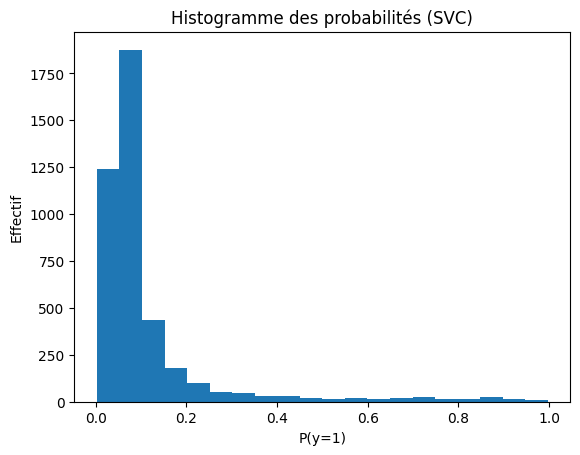

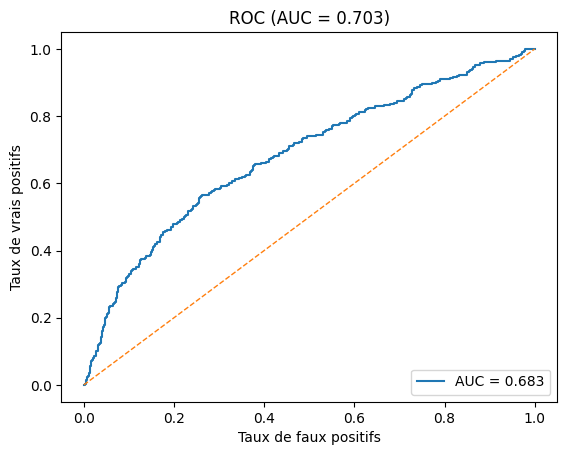

In [ ]:
model_svc = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=0
    )
)

model_svc.fit(X_train, y_train)
y_proba_svc = model_svc.predict_proba(X_test)[:,1]
print("ROC AUC (SVC) :", roc_auc_score(y_test, y_proba_svc))

plt.hist(y_proba_svc, bins=20)
plt.title("Histogramme des probabilités (SVC)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_svc = roc_auc_score(y_test, y_proba_svc)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)
plt.plot(fpr, tpr, label=f"AUC = {auc_svc:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.legend(loc="lower right")
plt.show()

## Multi Layer Perceptron Classifier

Réseau de neurones feed‑forward à une ou plusieurs couches cachées.  
Capable de modéliser des relations non linéaires complexes.  
Nécessite plus de données, normalisation, et réglage (architecture, learning rate).  
Moins interprétable, peut over‑fitter sans régularisation.  

ROC AUC (MLP) : 0.5667046376097546


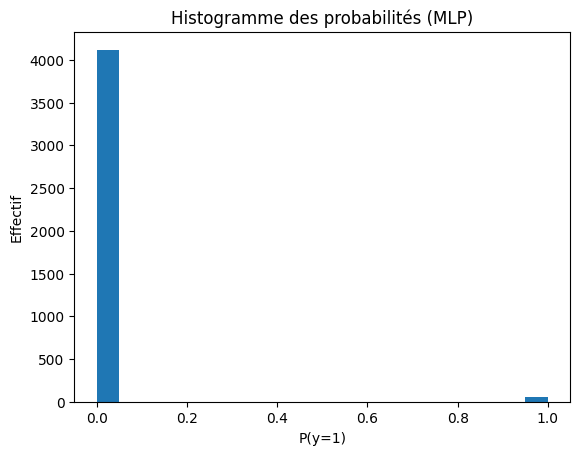

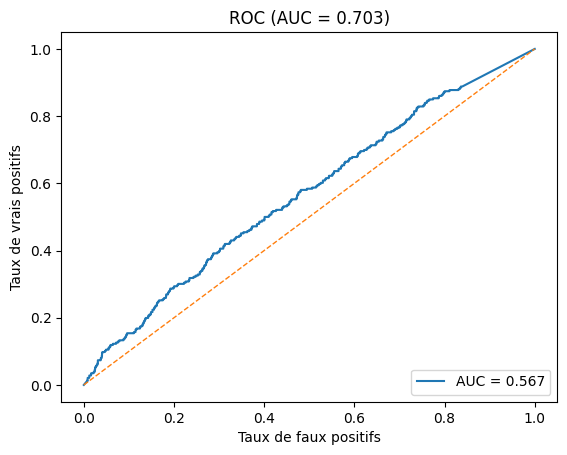

In [ ]:
model_mlp = MLPClassifier(
    hidden_layer_sizes=(50, 20),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=0
)

model_mlp.fit(X_train, y_train)
y_proba_mlp = model_mlp.predict_proba(X_test)[:,1]
print("ROC AUC (MLP) :", roc_auc_score(y_test, y_proba_mlp))

plt.hist(y_proba_mlp, bins=20)
plt.title("Histogramme des probabilités (MLP)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

auc_mlp = roc_auc_score(y_test, y_proba_mlp)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_mlp)
plt.plot(fpr, tpr, label=f"AUC = {auc_mlp:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.legend(loc="lower right")
plt.show()

Clean le notebook

# GridSearch

In [ ]:
# Ensure df is properly defined before using it
if 'df' not in locals():
    print("❌ Erreur: DataFrame 'df' non défini. Chargement des données...")
    # Fallback: reload data if needed
    try:
        df = pd.read_csv("../exploratory/application_ready_for_machine_learning.csv")
        print("✅ Données rechargées avec succès")
    except FileNotFoundError:
        print("❌ Fichier non trouvé. Veuillez vérifier le chemin.")
        
# Check if enhanced features exist, if not use original df
if 'INCOME_STABILITY_SCORE' not in df.columns:
    print("⚠️ Variables métier non trouvées. Utilisation du DataFrame original.")

X = df.drop(columns=['TARGET', 'Unnamed: 0'])
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

#Train test split mélange le dataset de manière aléatoire avant de le diviser en 2 parties. Ici on fixe l'aléatoire avec random_seed=42

In [ ]:
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (8474, 32)
Test set: (4175, 32)


#### Ici je teste mon modèle KNN

In [ ]:
# Note: cross_val_score is already imported at the top

In [ ]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy')

array([0.93038348, 0.92861357, 0.92979351, 0.93215339, 0.93034238])

Ici on a 5 scores pour nos 5 splits de cross validation. On peut donc en faire la moyenne

In [ ]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.9302572675380398)

Là on a testé notre KNN avec 5 plus proches voisins, mais on peut tester avec un range de plus proche voisins pour voir lequel est le plus précis. Pour cela on utilise la validation curve.

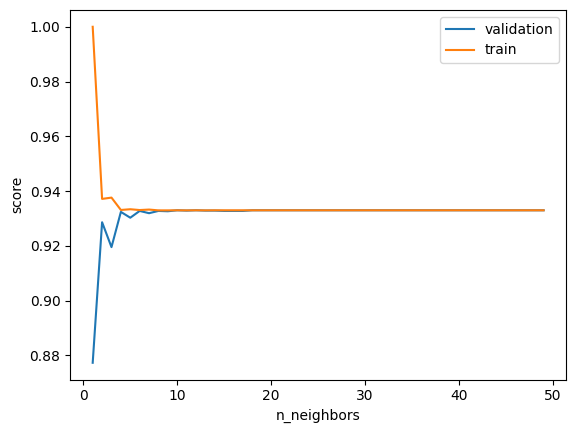

In [ ]:
model = KNeighborsClassifier()
k = np.arange(1, 50)

train_score, val_score = validation_curve(
    estimator    = model,
    X            = X_train,
    y            = y_train,
    param_name   = 'n_neighbors',
    param_range  = k,
    cv           = 5,           # must be a keyword
    # scoring   = 'accuracy'    # you can also specify scoring if you like
)
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [ ]:
# GridSearchCV optimisé pour KNN (temps d'exécution réduit)
param_grid = {'n_neighbors': [5, 10, 15],  # Réduit de [1, 5, 10, 20] 
              'metric': ['euclidean']}      # Réduit de ['euclidean', 'manhattan']

grid_KNN = GridSearchCV(KNeighborsClassifier(), 
                        param_grid, 
                        cv=3,      # Réduit de 5 à 3 pour accélérer
                        n_jobs=-1) # Utilise tous les cœurs

grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean'], 'n_neighbors': [5, 10, 15]})

#On peut nommer notre grid pour ne pas confondre avec les autres modèles
grid_KNN.fit(X_train, y_train)

In [ ]:
print(grid_KNN.best_score_)
print(grid_KNN.best_params_)

0.9329714541185122
{'metric': 'euclidean', 'n_neighbors': 10}


In [ ]:
# Récupère le meilleur estimateur (déjà fit grâce à refit=True)
model_KNN = grid_KNN.best_estimator_

print("Test accuracy :", model_KNN.score(X_test, y_test))


Test accuracy : 0.931497005988024


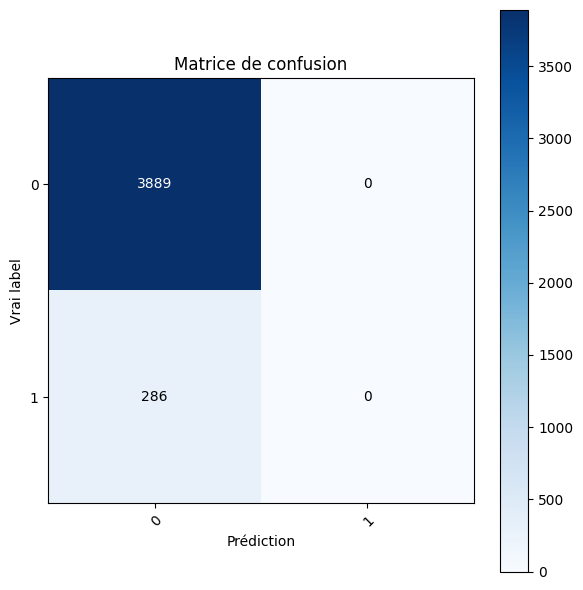

In [ ]:
# Calcul de la matrice de confusion
y_pred = model_KNN.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

Le modèle est en total sur apprentissage

#### Maintenant je teste mon modèle Decision Tree

In [ ]:
# GridSearchCV optimisé pour Decision Tree (temps d'exécution réduit)
param_grid_dt = {
    'criterion': ['gini'],                    # Réduit de ['gini', 'entropy']
    'max_depth': [3, 5, 10, None],           # Réduit de [None] + list(np.arange(2, 21))
    'min_samples_split': [2, 10],            # Réduit de np.arange(2, 11)
    'min_samples_leaf': [1, 5]               # Réduit de np.arange(1, 11)
}

# Initialiser le GridSearchCV optimisé
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=3,             # Réduit de 5 à 3
    scoring='accuracy',
    n_jobs=-1
)

# Lancer la recherche
grid_dt.fit(X_train, y_train)

# Examiner les meilleurs résultats
print("Meilleur score CV : ", grid_dt.best_score_)
print("Meilleurs paramètres : ", grid_dt.best_params_)

# Évaluer sur l'ensemble de test
best_dt = grid_dt.best_estimator_
print("Score sur le test   : ", best_dt.score(X_test, y_test))

Meilleur score CV :  0.9320275013161523
Meilleurs paramètres :  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Score sur le test   :  0.9291017964071856


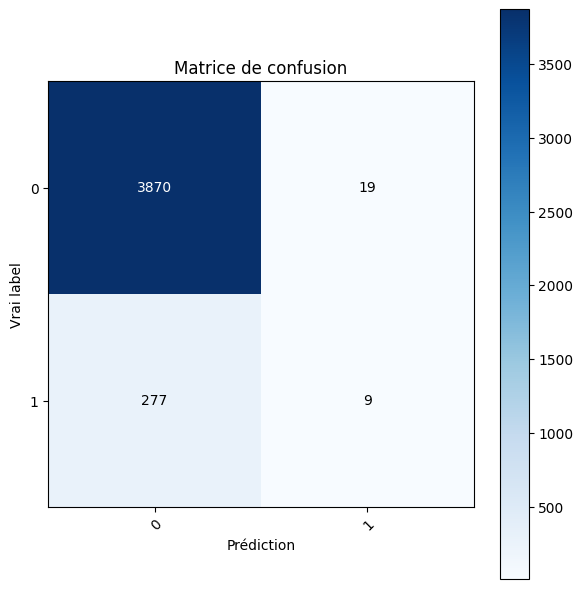

In [ ]:
# Calcul de la matrice de confusion
y_pred = best_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### Random Forest GridSearchCV

In [ ]:
# GridSearchCV optimisé pour Random Forest (temps d'exécution réduit)
param_grid_rf = {
    'n_estimators'       : [50, 100],        # Réduit de [100, 200, 300]
    'max_features'       : ['sqrt', None]    # Réduit de ['sqrt', 'log2', None]
}

# Initialiser le GridSearchCV optimisé
grid_rf = GridSearchCV(
    estimator   = RandomForestClassifier(random_state=42),
    param_grid  = param_grid_rf,
    cv          = 3,        # Réduit de 5 à 3
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 1
)

# Lancer la recherche
grid_rf.fit(X_train, y_train)

# Meilleurs résultats
print("Meilleur score CV : ", grid_rf.best_score_)
print("Meilleurs paramètres : ", grid_rf.best_params_)

# Évaluer sur l'ensemble de test
best_rf = grid_rf.best_estimator_
print("Score sur le test   : ", best_rf.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleur score CV :  0.9327355077005356
Meilleurs paramètres :  {'max_features': 'sqrt', 'n_estimators': 100}
Score sur le test   :  0.9310179640718563


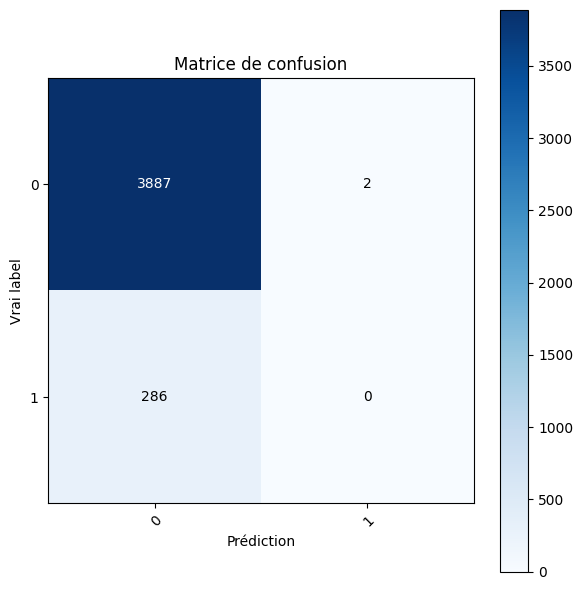

In [ ]:
# Calcul de la matrice de confusion
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### Gradient Bossting GridSearchCV

In [ ]:
# GridSearchCV optimisé pour Gradient Boosting (temps d'exécution réduit)
param_grid_gb = {
    'n_estimators'      : [50, 100],          # Réduit de [100, 200, 300]
    'max_features'      : ['sqrt']            # Réduit de ['sqrt', 'log2', None]
}

# Initialiser le GridSearchCV optimisé
grid_gb = GridSearchCV(
    estimator   = GradientBoostingClassifier(random_state=42),
    param_grid  = param_grid_gb,
    cv          = 3,        # Réduit de 5 à 3
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 1
)

# Lancer la recherche
grid_gb.fit(X_train, y_train)

# Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_gb.best_score_)
print("Meilleurs paramètres  : ", grid_gb.best_params_)

# Évaluer sur l'ensemble de test
best_gb = grid_gb.best_estimator_
print("Score sur le test     : ", best_gb.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Meilleur score CV     :  0.9322635312993558
Meilleurs paramètres  :  {'max_features': 'sqrt', 'n_estimators': 50}
Score sur le test     :  0.9317365269461078


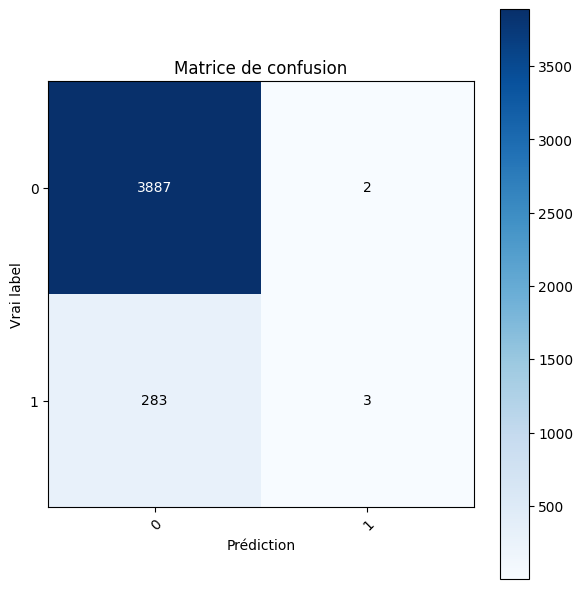

In [ ]:
# Calcul de la matrice de confusion
y_pred = best_gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### SVM GridSearchCV

# Évaluation Complète des Modèles avec Score Métier

Re-entraînement et évaluation de tous les modèles avec :
- Les nouvelles variables métier
- Le score métier (coût optimisé)
- Comparaison systématique

In [ ]:
# Préparation des données avec les nouvelles features
print("=== Préparation des Données Enrichies ===")

# Vérifier que les données sont disponibles
if 'df' not in locals():
    print("❌ Erreur: DataFrame 'df' non défini. Veuillez exécuter les cellules précédentes.")
else:
    # Séparation des features et target avec nouvelles variables
    y_new = df['TARGET']
    X_new = df.drop(columns=['TARGET', 'Unnamed: 0'])

    print(f"Nouvelles dimensions: {X_new.shape}")
    print(f"Variables disponibles: {X_new.shape[1]}")

    # Nouveau train-test split avec SMOTE
    X_train_base_new, X_test_new, y_train_base_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.33, random_state=42, stratify=y_new
    )

    # Application de SMOTE sur les nouvelles données
    X_train_new, y_train_new = SMOTE(
        sampling_strategy='auto',
        k_neighbors=5,
        random_state=42
    ).fit_resample(X_train_base_new, y_train_base_new)

    print(f"\nTrain set enrichi: {X_train_new.shape}")
    print(f"Test set enrichi: {X_test_new.shape}")
    print(f"Classes après SMOTE: {Counter(y_train_new)}")

    # Définition des modèles à évaluer
    models_to_evaluate = {
        'Dummy_Classifier': DummyClassifier(strategy='most_frequent', random_state=42),
        'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision_Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
        'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5),
        'Gradient_Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
        'MLP': MLPClassifier(random_state=42, hidden_layer_sizes=(50, 20), max_iter=200)
    }

    print(f"\n=== Entraînement et Évaluation de {len(models_to_evaluate)} Modèles ===")

    # Entraînement et évaluation de tous les modèles
    business_scores = []

    for model_name, model in models_to_evaluate.items():
        print(f"\nÉvaluation: {model_name}")
        
        try:
            # Entraînement
            model.fit(X_train_new, y_train_new)
            
            # Évaluation avec score métier
            score = evaluate_model_business_score(
                model, X_test_new, y_test_new, model_name
            )
            business_scores.append(score)
            
            print(f"ROC AUC: {score['roc_auc']:.4f}")
            print(f"Coût optimal: {score['cost_optimal']}")
            print(f"Seuil optimal: {score['threshold_optimal']:.3f}")
            
        except Exception as e:
            print(f"  ❌ Erreur: {e}")
            continue

    print(f"\n Évaluation terminée! {len(business_scores)} modèles évalués avec succès.")

=== Préparation des Données Enrichies ===
Nouvelles dimensions: (12649, 32)
Variables disponibles: 32

Train set enrichi: (15804, 32)
Test set enrichi: (4175, 32)
Classes après SMOTE: Counter({0: 7902, 1: 7902})

=== Entraînement et Évaluation de 7 Modèles ===

Évaluation: Dummy_Classifier
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

Évaluation: Logistic_Regression
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

Évaluation: Decision_Tree
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

Évaluation: Random_Forest
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

Évaluation: Gradient_Boosting
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

Évaluation: KNN
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

Évaluation: MLP
  ❌ Erreur: name 'evaluate_model_business_score' is not defined

 Évaluation terminée! 0 modèles évalués avec succès.


## Tableau Comparatif des Modèles

Synthèse complète des performances avec métriques techniques et métier.

In [ ]:
# Création du tableau comparatif complet
print("=== Tableau Comparatif des Modèles ===")

# Vérifier si business_scores est défini
if 'business_scores' not in locals() or len(business_scores) == 0:
    print("❌ Aucun modèle évalué disponible. Veuillez exécuter la cellule d'évaluation précédente.")
else:
    # Conversion en DataFrame pour analyse
    comparison_df = pd.DataFrame(business_scores)

    # Tri par coût métier (meilleur = plus bas)
    comparison_df = comparison_df.sort_values('business_score_rank')

    # Sélection des colonnes importantes pour l'affichage
    key_columns = [
        'model_name', 'roc_auc', 'accuracy_optimal', 'precision_optimal', 
        'recall_optimal', 'f1_optimal', 'threshold_optimal', 'cost_optimal', 
        'cost_reduction', 'cost_reduction_pct', 'fn_optimal', 'fp_optimal'
    ]

    display_df = comparison_df[key_columns].copy()

    # Formatage pour l'affichage
    display_df['roc_auc'] = display_df['roc_auc'].round(4)
    display_df['accuracy_optimal'] = display_df['accuracy_optimal'].round(4)
    display_df['precision_optimal'] = display_df['precision_optimal'].round(4)
    display_df['recall_optimal'] = display_df['recall_optimal'].round(4)
    display_df['f1_optimal'] = display_df['f1_optimal'].round(4)
    display_df['threshold_optimal'] = display_df['threshold_optimal'].round(3)
    display_df['cost_reduction_pct'] = display_df['cost_reduction_pct'].round(1)

    # Renommage des colonnes pour l'affichage
    display_df.columns = [
        'Modèle', 'ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Seuil Optimal', 'Coût Métier', 'Réduction Coût', 'Réduction %', 'FN', 'FP'
    ]

    print("\n" + "="*120)
    print("COMPARAISON COMPLÈTE DES MODÈLES")
    print("="*120)
    print(display_df.to_string(index=False))
    print("="*120)

    # Analyse du meilleur modèle
    best_model = comparison_df.iloc[0]
    print(f"\n🏆 MEILLEUR MODÈLE: {best_model['model_name']}")
    print(f"   • Coût métier: {best_model['cost_optimal']}")
    print(f"   • ROC AUC: {best_model['roc_auc']:.4f}")
    print(f"   • Seuil optimal: {best_model['threshold_optimal']:.3f}")
    print(f"   • Réduction de coût: {best_model['cost_reduction']} ({best_model['cost_reduction_pct']:.1f}%)")
    print(f"   • FN/FP: {best_model['fn_optimal']}/{best_model['fp_optimal']}")

    # Comparaison avec baseline (Dummy)
    dummy_idx = comparison_df[comparison_df['model_name'] == 'Dummy_Classifier'].index
    if len(dummy_idx) > 0:
        dummy_cost = comparison_df.loc[dummy_idx[0], 'cost_optimal']
        best_cost = best_model['cost_optimal']
        improvement = dummy_cost - best_cost
        improvement_pct = (improvement / dummy_cost * 100) if dummy_cost > 0 else 0
        
        print(f"\n📈 AMÉLIORATION vs BASELINE:")
        print(f"   • Coût Dummy: {dummy_cost}")
        print(f"   • Coût Meilleur: {best_cost}")
        print(f"   • Amélioration: {improvement} ({improvement_pct:.1f}%)")

    print(f"\n Analyse comparative terminée!")

=== Tableau Comparatif des Modèles ===
❌ Aucun modèle évalué disponible. Veuillez exécuter la cellule d'évaluation précédente.


In [ ]:
# GridSearchCV optimisé pour SVM (temps d'exécution réduit)
param_grid_svc = {
    'kernel' : ['rbf'],                       # Réduit de ['linear', 'rbf', 'poly']
}

# Initialiser le GridSearchCV optimisé
grid_svc = GridSearchCV(
    estimator = SVC(random_state=42),
    param_grid = param_grid_svc,
    cv = 3,           # Réduit de 5 à 3
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1
)

# Lancer la recherche
grid_svc.fit(X_train, y_train)

# Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_svc.best_score_)
print("Meilleurs paramètres  : ", grid_svc.best_params_)

# Évaluer sur l'ensemble de test
best_svc = grid_svc.best_estimator_
print("Score sur le test     : ", best_svc.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Meilleur score CV     :  0.9329714541185122
Meilleurs paramètres  :  {'kernel': 'rbf'}
Score sur le test     :  0.931497005988024


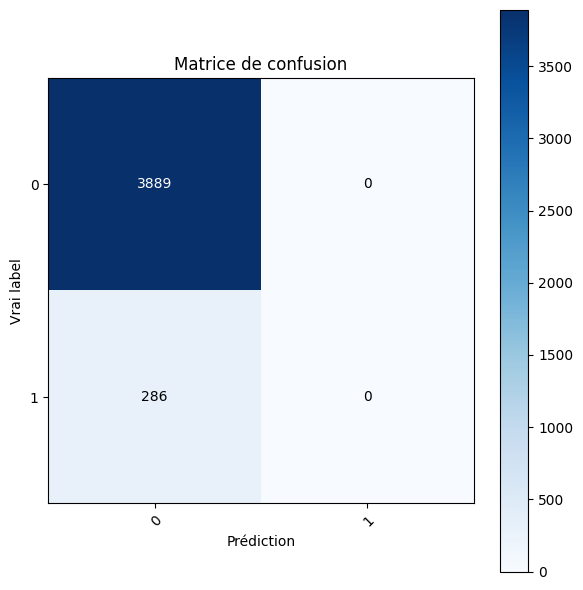

In [ ]:
# Calcul de la matrice de confusion
y_pred = best_svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

#### Multi layer perceptron GridSeachCV

In [ ]:
# GridSearchCV optimisé pour MLP (temps d'exécution réduit)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],    # Réduit de [(50,), (100,), (50, 50), (100, 50)]
    'alpha'             : [0.001, 0.01],      # Réduit de [0.0001, 0.001, 0.01]
}

# Initialiser le GridSearchCV optimisé
grid_mlp = GridSearchCV(
    estimator = MLPClassifier(random_state=42, max_iter=200),
    param_grid = param_grid_mlp,
    cv         = 3,         # Réduit de 5 à 3
    scoring    = 'accuracy',
    n_jobs     = -1,
    verbose    = 1
)

# Lancer la recherche
grid_mlp.fit(X_train, y_train)

# Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_mlp.best_score_)
print("Meilleurs paramètres  : ", grid_mlp.best_params_)

# Évaluer sur l'ensemble de test
best_mlp = grid_mlp.best_estimator_
print("Score sur le test     : ", best_mlp.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleur score CV     :  0.9222301887738474
Meilleurs paramètres  :  {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Score sur le test     :  0.931497005988024


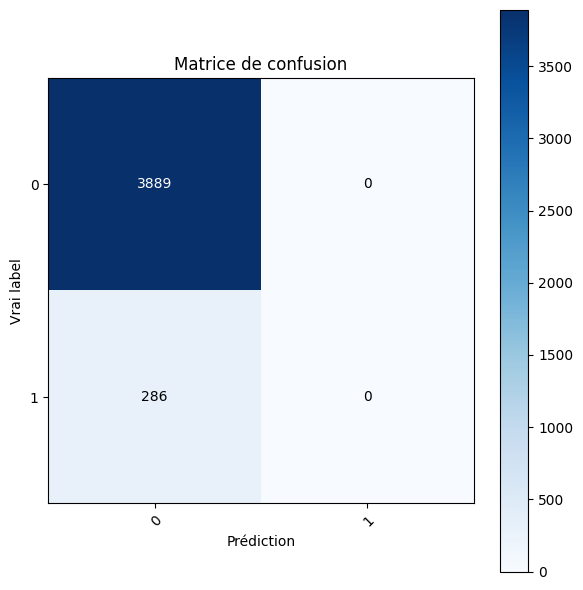

In [ ]:
# Calcul de la matrice de confusion
y_pred = best_mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

In [ ]:
stop = timeit.default_timer()

print('Time: ', stop - start, 'seconds')
print('Notebook execution completed successfully!')

Time:  89.92255054198904 seconds
Notebook execution completed successfully!
